In [1]:
from tensorflow.keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores

from optimus5_utils import load_optimus5_data, load_optimus5_predictor, animate_optimus5_examples


2021-12-08 06:10:22.777042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-08 06:10:25.566680: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-08 06:10:25.568043: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-08 06:10:25.593662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 06:10:25.594254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:

In [2]:
#Load Optimus-5 data and predictor

encoder = OneHotEncoder(seq_length=50, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

train_data_path = 'bottom5KIFuAUGTop5KIFuAUG.csv'
test_data_path = 'randomSampleTestingAllAUGtypes.csv'

x_train, y_train, x_test, y_test = load_optimus5_data(train_data_path, test_data_path)

predictor_path = 'saved_models/optimusRetrainedMain.hdf5'

predictor = load_optimus5_predictor(predictor_path)


x_train.shape = (15008, 1, 50, 4)
x_test.shape = (3200, 1, 50, 4)
y_train.shape = (15008, 1)
y_test.shape = (3200, 1)


2021-12-08 06:10:30.366040: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-08 06:10:30.366300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 06:10:30.366846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-12-08 06:10:30.366883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-08 06:10:30.366928: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-08 06:10:30.366951: I tensorflow/stream_executor/platform/default/dso

In [3]:
#Define sequence template and background

sequence_template = '$' * 50

pseudo_count = 1.0

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)


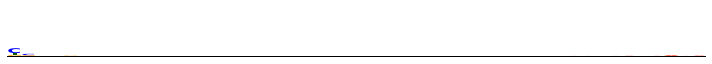

In [4]:
#Visualize background sequence distribution

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(10, 1), logo_height=1.0, plot_start=0, plot_end=50)


In [5]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.9679329305814974


In [6]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=50,
    n_out_channels=4,
    input_templates=[onehot_template],
    input_backgrounds=[x_mean],
    batch_size=32,
    n_samples=32,
    sample_mode='gumbel',
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config
)


In [7]:
#Load pre-trained scrambler model
save_dir = 'saved_models'

model_name = 'optimus5_inclusion_scrambler_bits_0125_epochs_10'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.load_model(model_path)


Loaded scrambler model from saved_models/optimus5_inclusion_scrambler_bits_0125_epochs_10.h5 


In [8]:
#Interpret the test set using the trained scrambler
pretrained_pwm_test, pretrained_sample_test, pretrained_importance_scores_test = scrambler.interpret(x_test[:128])


2021-12-08 06:10:35.236438: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-08 06:10:35.254126: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300020000 Hz
2021-12-08 06:10:36.837286: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-08 06:10:37.412478: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


4/4 [==============================] - 2s 18ms/step


In [9]:
#Interpret the test set using the trained scrambler
finetuned_pwm_test, finetuned_sample_test, finetuned_importance_scores_test, finetuned_histories = scrambler.optimize(
    predictor,
    x_test[:128],
    y_test[:128],
    batch_size=32,
    n_iters=500,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='maximization',
    entropy_bits=0.125,
    entropy_weight=10.
)


n batches:  4
Finetuning batch 0...
500
500/500 [==============================] - 4s 3ms/step - loss: 199.4994 - ft_nll_loss: 117.1312 - ft_entropy_loss: 82.3682
500
500/500 [==============================] - 3s 2ms/step - loss: 158.0917 - ft_nll_loss: 128.9275 - ft_entropy_loss: 29.1642
500
500/500 [==============================] - 3s 2ms/step - loss: 126.3308 - ft_nll_loss: 124.5655 - ft_entropy_loss: 1.7653
500
500/500 [==============================] - 3s 2ms/step - loss: 134.3477 - ft_nll_loss: 134.2955 - ft_entropy_loss: 0.0522


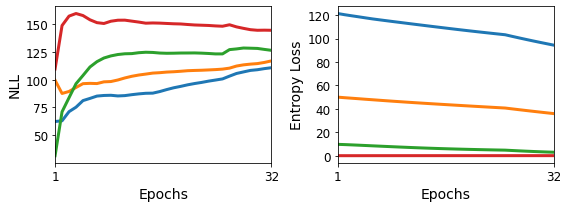

In [12]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(finetuned_histories[0]['ft_nll'])

nll_rolling_window = 25
entropy_rolling_window = 25

for i in range(len(finetuned_histories)) :
    ax1.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.array(finetuned_histories[i]['ft_nll']), window=nll_rolling_window), linewidth=3)
    
plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

for i in range(len(finetuned_histories)) :
    ax2.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.array(finetuned_histories[i]['ft_entropy']), window=entropy_rolling_window), linewidth=3)

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


Test sequence 0:
 - Prediction (original) = -1.0
 - Predictions (scrambled, pretrained) = [-1.4, -1.0, -1.5, -0.9, -1.4, -1.2, -1.5, -1.1, -1.1, -0.9, -1.4, -0.7, -0.9, -1.3, -0.7, -0.7, -1.3, -1.1, -1.4, -1.3, -1.0, -1.4, -1.2, -1.9, -0.8, -0.7, -1.3, -0.9, -1.3, -1.1, -1.3, -1.1]
 - Predictions (scrambled, finetuned) = [-0.2, 0.36, -0.4, 0.68, -0.6, 0.32, 0.47, 0.61, 0.52, 0.57, 0.59, 0.39, -0.2, 0.7, 0.56, -0.6, 0.7, 0.53, 0.47, 0.38, 0.13, 0.54, 0.63, 0.57, 0.4, 0.45, 0.54, 0.29, 0.49, 0.55, 0.68, 0.78]


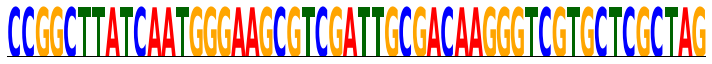

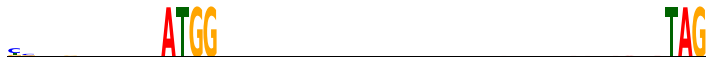

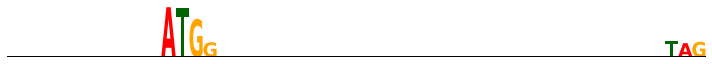

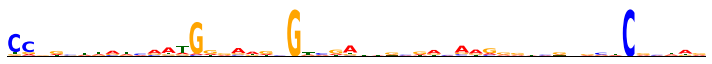

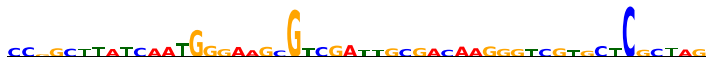

Test sequence 1:
 - Prediction (original) = -1.0
 - Predictions (scrambled, pretrained) = [-1.1, -1.2, -0.8, -1.4, -1.3, -0.5, -1.0, -1.3, -0.8, -1.5, -1.3, -1.0, -1.2, -1.0, -1.2, -0.6, -1.3, -1.2, -1.0, -1.2, -1.1, -0.9, -1.1, -1.4, -1.1, -0.7, -1.0, -1.2, -1.1, -0.8, -1.2, -1.3]
 - Predictions (scrambled, finetuned) = [0.51, 0.07, 0.63, 0.63, -0.7, -0.1, 0.6, 0.38, 0.75, 0.89, 0.57, -0.3, -0.9, 0.67, 0.29, 0.7, 0.31, 0.34, 0.76, -0.4, 0.58, 0.32, -0.2, 0.41, -0.5, 0.49, 0.07, -0.0, 0.64, 0.36, 0.63, -0.5]


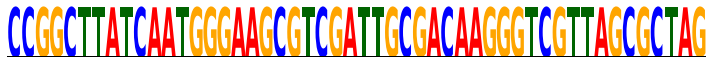

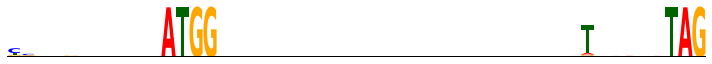

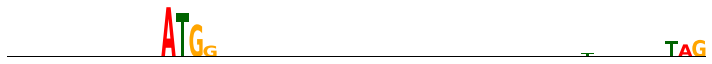

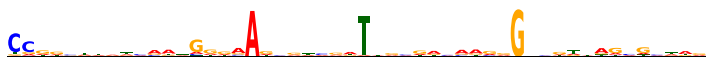

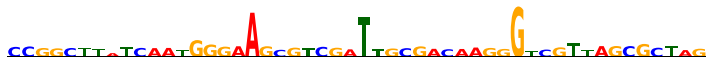

Test sequence 2:
 - Prediction (original) = -0.9
 - Predictions (scrambled, pretrained) = [-0.0, -0.6, -1.0, -0.7, -1.1, -0.6, -1.4, 0.2, -0.3, -0.0, -1.1, -0.6, -0.3, -1.3, -0.8, -0.9, -0.5, -1.0, -0.7, -0.9, -1.0, -0.7, -0.8, -0.8, -0.6, -0.7, -0.4, -0.4, -0.2, -0.3, -0.3, -1.2]
 - Predictions (scrambled, finetuned) = [0.77, 0.74, 0.68, 0.72, -1.4, 0.83, 0.4, 0.52, 0.57, 0.69, 0.53, 0.66, -0.1, -0.4, 0.72, 0.26, 0.73, 0.85, 0.67, 0.48, 0.5, 0.59, 0.84, 0.67, 0.74, 0.62, 0.33, 0.62, 0.46, -1.2, 0.62, 0.14]


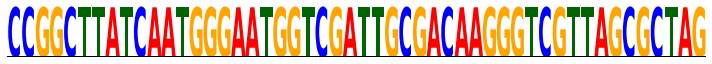

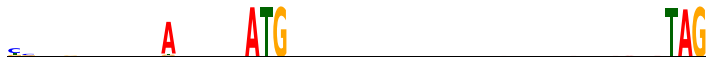

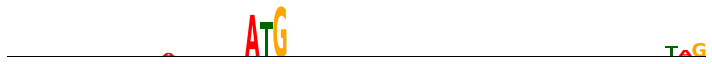

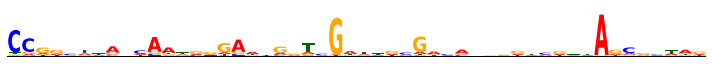

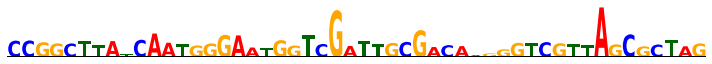

Test sequence 3:
 - Prediction (original) = -1.1
 - Predictions (scrambled, pretrained) = [0.88, 0.78, 0.73, -0.0, 0.76, 0.78, 0.87, 0.56, -0.1, 0.82, 0.8, 0.89, 0.77, 0.77, -0.1, 0.79, -0.2, 0.79, 0.65, 0.76, 0.8, 0.63, 0.74, 0.67, 0.68, -0.6, -0.0, 0.84, -0.8, 0.77, 0.74, 0.63]
 - Predictions (scrambled, finetuned) = [0.55, 0.07, -0.4, 0.56, 0.38, 0.65, 0.5, 0.59, 0.61, 0.44, -0.4, 0.38, 0.56, 0.31, 0.04, 0.58, 0.42, 0.45, 0.52, 0.66, 0.45, 0.58, 0.72, -0.4, 0.51, 0.32, 0.43, 0.7, 0.74, 0.48, 0.48, 0.33]


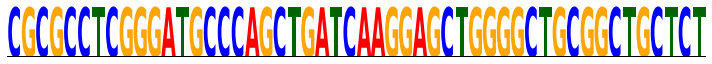

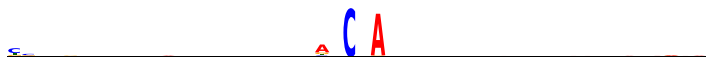

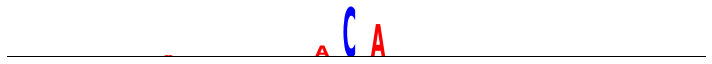

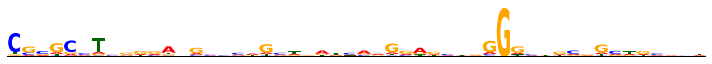

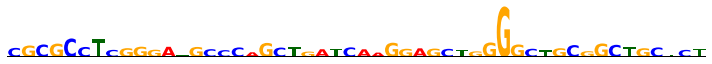

Test sequence 4:
 - Prediction (original) = -1.2
 - Predictions (scrambled, pretrained) = [-1.4, -0.9, 0.56, -0.4, -1.9, -0.3, -0.8, -1.1, 0.05, -1.2, -0.3, -1.7, -1.7, -0.1, -0.5, -0.0, -1.5, -0.5, -0.8, -1.5, -1.9, -0.6, -1.9, -0.9, -1.4, -0.3, -1.2, -0.6, -1.0, -0.5, -1.3, -0.4]
 - Predictions (scrambled, finetuned) = [0.47, 0.67, 0.4, 0.49, 0.72, -0.1, 0.53, 0.46, -0.1, 0.37, 0.37, -0.5, 0.57, 0.43, 0.64, -0.1, 0.78, 0.52, 0.23, 0.01, 0.32, 0.36, -0.0, 0.48, 0.2, 0.6, -0.4, 0.05, 0.68, 0.39, -0.9, 0.64]


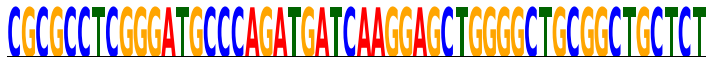

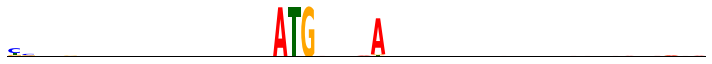

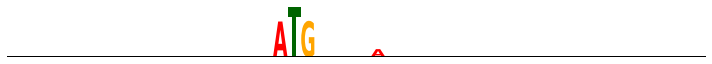

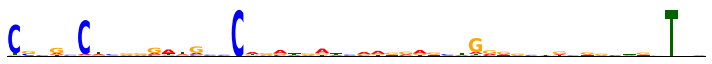

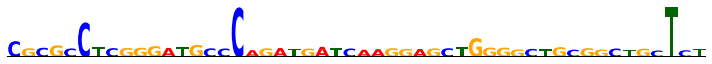

In [13]:
#Visualize a few reconstructed sequence patterns

plot_examples = np.arange(5).tolist()
save_examples = []

pretrained_importance_scores_test *= sequence_mask[None, None, :, None]
finetuned_importance_scores_test *= sequence_mask[None, None, :, None]

for test_ix in plot_examples :
    
    print("Test sequence " + str(test_ix) + ":")
    
    y_test_hat_ref = predictor.predict(x=[x_test[test_ix:test_ix+1, ...]], batch_size=1)[0, 0]
    y_test_hat_pretrained = predictor.predict(x=[pretrained_sample_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
    y_test_hat_finetuned = predictor.predict(x=[finetuned_sample_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled, pretrained) = " + str([float(str(round(y_test_hat_pretrained[i], 2))[:4]) for i in range(len(y_test_hat_pretrained))]))
    print(" - Predictions (scrambled, finetuned) = " + str([float(str(round(y_test_hat_finetuned[i], 2))[:4]) for i in range(len(y_test_hat_finetuned))]))
    
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    plot_dna_logo(x_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=50, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence")
    
    plot_dna_logo(pretrained_pwm_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=50, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm_pretrained")
    plot_dna_importance_scores(pretrained_importance_scores_test[test_ix, 0, :, :].T, encoder.decode(x_test[test_ix, 0, :, :]), figsize=(10, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=50, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores_pretrained")
    
    plot_dna_logo(finetuned_pwm_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=50, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm_finetuned")
    plot_dna_importance_scores(finetuned_importance_scores_test[test_ix, 0, :, :].T, encoder.decode(x_test[test_ix, 0, :, :]), figsize=(10, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=50, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores_finetuned")
    